<a href="https://colab.research.google.com/github/itzrnvr/opencv-labs/blob/main/lab10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import os

In [2]:
IMAGE_DL = {
    "lena": ("images/lena.png", "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png"),
    "graf1": ("images/graf1.png", "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/graf1.png"),
    "graf3": ("images/graf3.png", "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/graf3.png"),
    "stereo_left": ("images/stereo_left.png", "https://vision.middlebury.edu/stereo/data/scenes2003/newdata/cones/im2.png"),
    "stereo_right": ("images/stereo_right.png", "https://vision.middlebury.edu/stereo/data/scenes2003/newdata/cones/im6.png")
}
PANORAMA_IMG1 = "image1.png"
PANORAMA_IMG2 = "image2.png"
HAAR_PATH = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'

Task 1: Image Stitching, Panorama, Structure from Motion, Inpainting

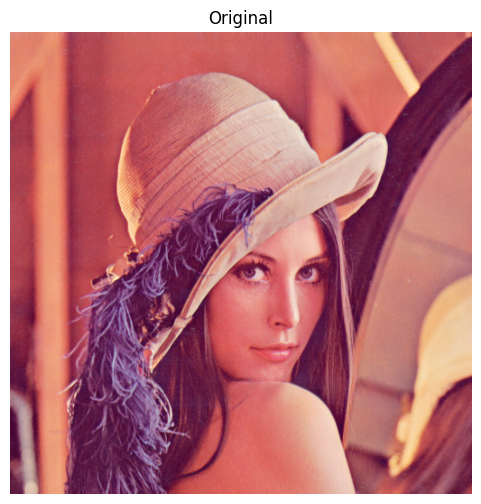

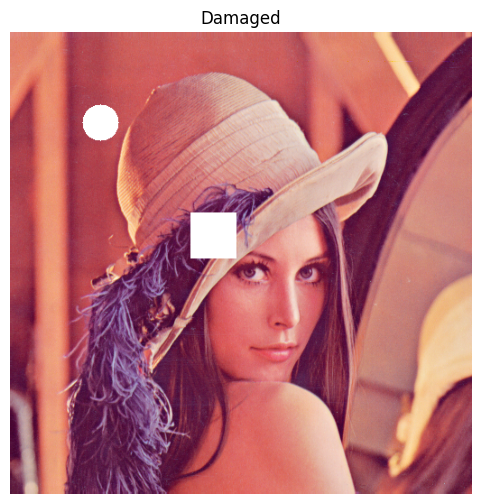

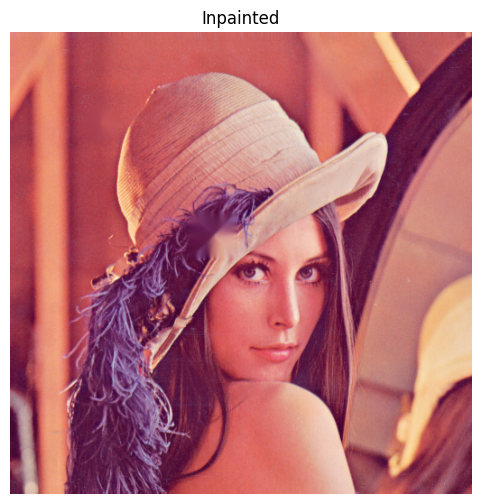

One or both panorama images not loaded. Please upload.


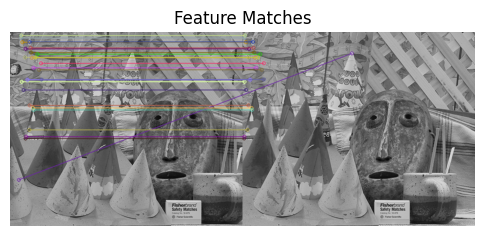

Fundamental Matrix:
 [[ 9.29807624e-07 -2.85671360e-04  4.37594991e-02]
 [ 2.96015959e-04 -2.07295211e-05  3.13553171e-01]
 [-4.45592451e-02 -3.18705338e-01  1.00000000e+00]]

Essential Matrix:
 [[-2.87910069e-08 -4.01022615e-05  8.48144291e-03]
 [ 4.06272839e-05 -4.05319857e-06 -7.07055913e-01]
 [-8.07512324e-03  7.07060670e-01 -4.03559667e-06]]


In [3]:
def _show(img, ttl, cmap=None):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap=cmap)
    plt.title(ttl)
    plt.axis('off')
    plt.show()
def _dl(url, fname):
    urllib.request.urlretrieve(url, fname)
os.makedirs("images", exist_ok=True)
for name, (fn, url) in IMAGE_DL.items():
    _dl(url, fn)
img_rgb = cv2.cvtColor(cv2.imread("images/lena.png"), cv2.COLOR_BGR2RGB)
img_g1 = cv2.cvtColor(cv2.imread("images/graf1.png"), cv2.COLOR_BGR2RGB)
img_g3 = cv2.cvtColor(cv2.imread("images/graf3.png"), cv2.COLOR_BGR2RGB)
img_left = cv2.imread("images/stereo_left.png", 0)
img_right = cv2.imread("images/stereo_right.png", 0)
masked = img_rgb.copy()
sh, sw = masked.shape[:2]
mk = np.zeros((sh, sw), dtype=np.uint8)
cv2.circle(mk, (100, 100), 20, 255, -1)
cv2.rectangle(mk, (200, 200), (250, 250), 255, -1)
masked[mk == 255] = 255
recon = cv2.inpaint(masked, mk, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
_show(img_rgb, "Original")
_show(masked, "Damaged")
_show(recon, "Inpainted")
p1 = cv2.imread(PANORAMA_IMG1)
p2 = cv2.imread(PANORAMA_IMG2)
if p1 is None or p2 is None:
    print("One or both panorama images not loaded. Please upload.")
else:
    print("Panorama images loaded.")
    p1_rgb = cv2.cvtColor(p1, cv2.COLOR_BGR2RGB)
    p2_rgb = cv2.cvtColor(p2, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1); plt.imshow(p1_rgb); plt.title('Image 1'); plt.axis('off')
    plt.subplot(1, 2, 2); plt.imshow(p2_rgb); plt.title('Image 2'); plt.axis('off')
    plt.show()
    stitch_inst = cv2.Stitcher_create()
    ret_code, stitched_im = stitch_inst.stitch([p1_rgb, p2_rgb])
    if ret_code == cv2.Stitcher_OK:
        print("Stitching successful.")
        plt.figure(figsize=(12, 6))
        plt.imshow(stitched_im)
        plt.title("Stitched Panorama")
        plt.axis('off')
        plt.show()
    else:
        print("Stitching failed. Status:", ret_code)
sfm_sift = cv2.SIFT_create()
kpL, desL = sfm_sift.detectAndCompute(img_left, None)
kpR, desR = sfm_sift.detectAndCompute(img_right, None)
flann_matcher = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
mat = flann_matcher.knnMatch(desL, desR, k=2)
sel_matches = [m for m, n in mat if m.distance < 0.7 * n.distance]
ptsL = np.float32([kpL[m.queryIdx].pt for m in sel_matches])
ptsR = np.float32([kpR[m.trainIdx].pt for m in sel_matches])
fm, _ = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_RANSAC)
em, _ = cv2.findEssentialMat(ptsL, ptsR)
sfm_draw = cv2.drawMatches(img_left, kpL, img_right, kpR, sel_matches[:30], None, flags=2)
_show(sfm_draw, "Feature Matches", cmap='gray')
print("Fundamental Matrix:\n", fm)
print("\nEssential Matrix:\n", em)


Task 2: Video Analysis

In [4]:
import cv2
import numpy as np
HAAR = cv2.CascadeClassifier(HAAR_PATH)
BGFG = cv2.createBackgroundSubtractorMOG2()
def frameproc(frm):
    f = cv2.resize(frm, (320,240))
    gray = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
    edg = cv2.Canny(gray, 100, 200)
    fft = np.fft.fftshift(np.fft.fft2(gray))
    mag = 20 * np.log(np.abs(fft) + 1)
    mag = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    fgmask = BGFG.apply(f)
    vis = f.copy()
    faces = HAAR.detectMultiScale(gray, 1.1, 4)
    for (x,y,w,h) in faces:
        cv2.rectangle(vis, (x,y), (x+w,y+h), (0,255,0), 2)
        cv2.putText(vis, "Face", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    edge3 = cv2.cvtColor(edg, cv2.COLOR_GRAY2BGR)
    fg3 = cv2.cvtColor(fgmask, cv2.COLOR_GRAY2BGR)
    mag3 = cv2.cvtColor(mag, cv2.COLOR_GRAY2BGR)
    vis = cv2.resize(vis, (320,240))
    grid = np.vstack([np.hstack([vis, edge3]), np.hstack([fg3, mag3])])
    return grid
def vidmain():
    vid = cv2.VideoCapture(0)
    if not vid.isOpened():
        print("No webcam access."); return
    print("Running... Press 'q' to quit.")
    while True:
        ok, frame = vid.read()
        if not ok:
            print("Frame capture failed."); break
        showframe = frameproc(frame)
        cv2.imshow("Video Analysis [Face | Edges | FG | FFT]", showframe)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    vid.release(); cv2.destroyAllWindows(); print("Exited.")
if __name__ == "__main__":
    vidmain()

No webcam access.
